In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import re
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from xgboost import plot_tree

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin/'

import sys
sys.path.insert(1, '../src/stproject')
from utils import *


pd.set_option('display.width', 500, 'display.max_rows', None, 'display.max_columns', None)
data_dir_raw = Path('../data')


In [25]:
# Generate dtrain
df_fe1 = pd.read_csv(data_dir_raw / 'df_fe1.csv', index_col=0)
df_fe1['mv'] = df_fe1['M'] / df_fe1['density']
df_fe1 = df_fe1[~df_fe1['molecule'].str.contains('Furan')]

# Removing data points with unused features for polyester prediction
features_unused = ['C#C', 'C-ring', 'OH', 'CHO', 'COOH']
df_fe1 = df_fe1.loc[df_fe1[features_unused].sum(axis=1) == 0, df_fe1.columns.difference(features_unused)]
print(len(df_fe1))

X = df_fe1.drop(['measured_st', 'molecule'], axis=1)
y = df_fe1['measured_st']
dtrain = xgb.DMatrix(X, label=y)
print(X.head())

198
    Ar    C  C-O-C  C=C   CH  CH-ring  CH2  CH2-ring  CH3   CO  COOR        M  density          mv
1  0.0  0.0    0.0  0.0  0.0      0.0  3.0       0.0  2.0  0.0   0.0   72.151  0.62638  115.187267
2  0.0  0.0    0.0  0.0  0.0      0.0  4.0       0.0  2.0  0.0   0.0   86.178  0.65940  130.691538
3  0.0  0.0    0.0  0.0  0.0      0.0  5.0       0.0  2.0  0.0   0.0  100.205  0.68420  146.455715
4  0.0  0.0    0.0  0.0  0.0      0.0  6.0       0.0  2.0  0.0   0.0  114.232  0.70310  162.469066
5  0.0  0.0    0.0  0.0  0.0      0.0  7.0       0.0  2.0  0.0   0.0  128.259  0.71760  178.733278


In [26]:
# default params
params_0 = {'learning_rate': 0.01,
            'n_estimators': 10000,
            'max_depth': 4,
            'min_child_weight': 2,
            'gamma': 0,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'nthread': 4,
            'seed': 42,
            'objective': 'reg:squarederror'}

In [27]:
# initial testing
xgb.cv(params=params_0, 
       dtrain=dtrain, 
       num_boost_round=10000, 
       early_stopping_rounds=100, 
       nfold=5, 
       metrics='rmse', 
       as_pandas=True, 
       seed=42)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,25.486296,0.149076,25.482673,0.602934
1,25.239125,0.147461,25.237926,0.603476
2,24.993708,0.146139,24.992242,0.601755
3,24.751486,0.143939,24.750937,0.600988
4,24.512696,0.143707,24.512112,0.598617
5,24.275496,0.143169,24.275245,0.595827
6,24.039924,0.142081,24.041031,0.590568
7,23.808448,0.141616,23.811767,0.589590
8,23.579069,0.140562,23.583537,0.587981
9,23.351460,0.139803,23.358027,0.583082


In [28]:
# feature importance

xgb_fi = XGBRegressor(learning_rate=0.01,
            n_estimators=10000,
            max_depth=4,
            min_child_weight=2,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=4,
            seed=42,
            objective='reg:squarederror')
xgb_fi.fit(X, y)

XGBRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=4,
             min_child_weight=2, n_estimators=10000, nthread=4,
             objective='reg:squarederror', seed=42, subsample=0.8)

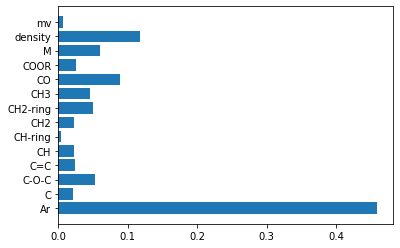

In [29]:
plt.barh(X.columns, xgb_fi.feature_importances_)
plt.show()

In [30]:
# Exclusion of 4 lowest importance features
X_trimmed = X.drop(['mv', 'CH-ring', 'CH', 'C', 'C=C', 'COOR'], axis=1)
dtrain_trimmed = xgb.DMatrix(X_trimmed, label=y)

In [31]:
# cross validation testing with X_trimmed
xgb.cv(params=params_0, 
       dtrain=dtrain_trimmed, 
       num_boost_round=5000, 
       early_stopping_rounds=100, 
       nfold=5, 
       metrics='rmse', 
       as_pandas=True, 
       seed=42)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,25.486296,0.149076,25.482672,0.602935
1,25.238794,0.147717,25.235653,0.601788
2,24.994259,0.146293,24.991047,0.600152
3,24.752667,0.145021,24.748605,0.601157
4,24.514491,0.144308,24.512189,0.600560
5,24.277437,0.143586,24.276300,0.598539
6,24.042015,0.142514,24.042068,0.593245
7,23.810047,0.142380,23.810323,0.590890
8,23.579834,0.141533,23.579805,0.588422
9,23.352431,0.140525,23.354864,0.584176
